In [1]:
import numpy as np
from matplotlib import pyplot as plt
from plot_utils import *

data = load_data('../stats/fpm_1_sliding_solver_1.json')

/home/porepy/porepy/src/porepy/numerics/nonlinear/nonlinear_solvers.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange  # type: ignore


Text(0.5, 0, '# matrix')

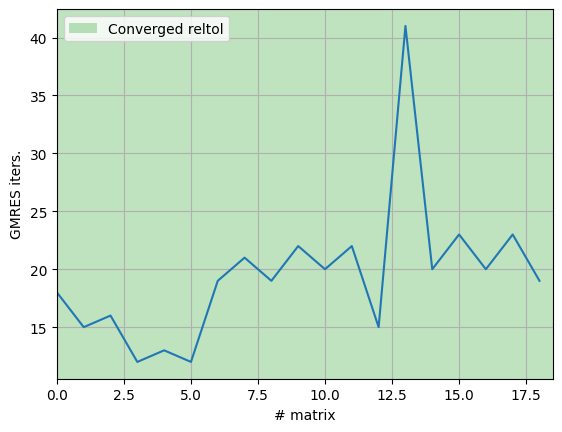

In [4]:
# %matplotlib ipympl

color_converged_reason(data)
plt.plot(get_gmres_iterations(data))
plt.ylabel('GMRES iters.')
plt.xlabel('# matrix')
# plt.yscale('log')

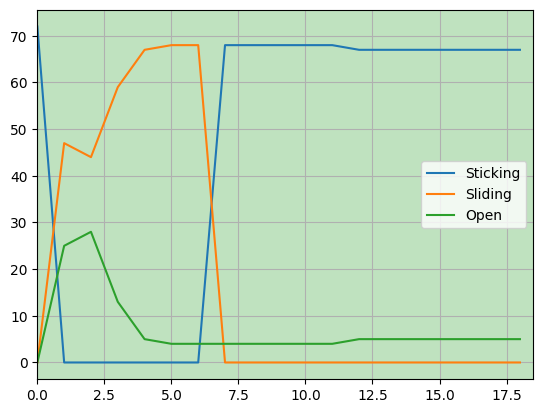

In [5]:
sticking, sliding, open_ = get_num_sticking_sliding_open(data)
color_converged_reason(data, legend=False)
plt.plot(sticking, label='Sticking')
plt.plot(sliding, label='Sliding')
plt.plot(open_, label='Open')
plt.legend()